# PythonDataIES project - bezrealitky.cz
Authors: Tiep Luu Danh, Jan Malecha

In [5]:
pip install fiona

  Using cached https://files.pythonhosted.org/packages/6d/42/f4a7cac53b28fa70e9a93d0e89a24d33e14826dad6644b699362ad84dde0/Fiona-1.8.13.post1.tar.gz


    ERROR: Complete output from command python setup.py egg_info:
    ERROR: A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    ----------------------------------------
ERROR: Command "python setup.py egg_info" failed with error code 1 in C:\Users\janek\AppData\Local\Temp\pip-install-hsrddcj3\fiona\


Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import tqdm as tqdm
from lxml import html
import time
import itertools
# import geopandas as gp
# import fiona
# import shapely
# import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

## Bezrealitky pages class structure

**Estate (parent)** - class containing general methods for parsing bezrealitky websites
 - **Flat (child)** - standard properties, no special naming of methods as it type of majority of observations
 - **NBFlat (child)** - new-build properties, a group of new build estates that have very different page, methods for this class end with NB

In [2]:
class Estate:
    '''
    Defined as parent class for all possible version of bezrealitky pages
    
    Containing general methods used in scraping these websites
    '''
    def __init__(self, link):
        self.link = link
        self.soup = self.getSoup
        
    def getSoup(self):
        '''
        Initialize soup object.
        '''
        r = requests.get(self.link)
        r.encoding = 'UTF-8'
        
        return BeautifulSoup(r.text, 'html')   

In [3]:
class Flat(Estate):
    def __init__(self, link):
        '''
        Constructor for Flat calls parents Estate constructor first,
        where self.link and self.soup are created
        
        Then flat parameters and coordinates are generated as Flat attributes
        '''
        # Calling Estate constructor
        super().__init__(link)
        
        # getting soup
        self.soup = self.getSoup()
        
        # Getting paramaters of flat
        self.parameters = self.getParameters()
        
        # Getting coordinates of flat
        self.coordinates = self.getMap()
        
        # Getting resulting dataframe
        self.df = self.getDf()
        
    def getParameters(self):
        '''
        Get parameters of given estate - such as price, disposition, the state of the house, etc.
        '''
        bf_table = self.soup.find('div',{'data-element':"detail-description"}).find('table')
        table_extract = [i.text.strip() for i in bf_table.findAll('tr')]
        df_table = pd.DataFrame(table_extract)
        df_table_split = df_table[0].str.split("\n", expand = True)
        df = pd.DataFrame(df_table_split[[0,1]])
        df.columns = ['metric', 'value']
        df = df.set_index('metric')
        
        return df
        
#     def getMap(self):
#         '''
#         Get location of the property using embeded Google maps longtitute and lattitude parameters.
#         '''
#         bf_map = self.soup.find('div',{'id':"map"})
#         x = bf_map.find('iframe')['src'].find('q=') + 2 
#         y = bf_map.find('iframe')['src'].find('&key')
#         location = bf_map.find('iframe')['src'][x:y]
#         loc_str = location.split(',')
#         loc_dict = {"lat" : [loc_str[0]], "long": [loc_str[1]]}
#         loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        
#         return loc_df
    def getMap(self):
        '''
        Get location of the property using longtitute and lattitude parameters.
        '''
        bf_map = self.soup.find('div','b-map__inner')
        f_lng = bf_map['data-lng']
        f_lat = bf_map['data-lat']
        loc_dict = {"lat" : f_lat, "long": f_lng}
        loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        return loc_df
    
    
    def getDf(self):
        '''
        Return a wide dataframe from getMap() and getParameters(), index = latitute and longtitude
        '''
        df_par = self.getParameters()
        df_map = self.getMap()
        df = pd.concat([df_par, df_map])
        df = df.T.set_index('Číslo inzerátu:')
#         df = pd.melt(df.T, id_vars = ['Číslo inzerátu:']).set_index('Číslo inzerátu:')
        return df    

**Example:**

In [4]:
Flat('https://www.bezrealitky.cz/nemovitosti-byty-domy/608778-nabidka-prodej-bytu-jilovska-hlavni-mesto-praha').getMap()

,value
lat,50.0239157
long,14.4284092


In [5]:
def NBFlat(Estate):
    def __init__(self, link):
        '''
        Constructor for new-build Flat calls parents Estate constructor first,
        where self.link and self.soup are created
        
        Then new-build flat parameters and (coordinates) are generated as NBFlat attributes
        '''
        # Calling Estate constructor
        super().__init__(link)
        
        # Getting soup
        self.soup = self.getSoup()
        
        # Getting paramaters of flat
        self.parameters = self.getParametersNB()
        
        # Getting coordinates of flat
#         self.coordinates = self.getMapNB()
    
    def getParametersNB(self): 
        '''
        For new-build properties get parameters such as price, disposition, the state of the house
        '''
        bf_table = self.soup.find('div', {'id':'tabInformace'}).find('table')
        bf_table
        table_extract = [li.text.strip() for li in bf_table.findAll('tr', {'class':'cline'})]
        df_table  = pd.DataFrame(table_extract)
        df_table_split = df_table[0].str.split("\n", expand = True)
        pd.DataFrame(df_table_split[[0,1]], columns = ['metric', 'value'])
        df  = pd.concat(
                        [pd.DataFrame(np.array(df_table_split[[0,1]]), columns = ['metric', 'value']),
                        pd.DataFrame(np.array(df_table_split[[2,3]]), columns = ['metric', 'value'])]
                        )

        return df
    
    def getDf(self):
        '''
        Return a wide dataframe from getMapNB() and getParametersNB(), index = latitute and longtitude
        '''
        df_par = self.getParameters()
        return df_par
#         df_map = self.getMap()
#         df = pd.concat([df_par, df_map])
#         df = pd.melt(df.T, id_vars = ['lat','long'])
#         return df
    
        
# FOLLOWING METHOD is currently work in progress
#     def getMapNB(self) 
#         '''
#         Get location of the property using embeded google maps longtitute and lattitude parameters
#         '''
#         bf = self.getSoup()
#         bf_map = bf.find('div',{'id':"map"})
#         x = bf_map.find('iframe')['src'].find('q=') + 2 
#         y = bf_map.find('iframe')['src'].find('&key')
#         location = bf_map.find('iframe')['src'][x:y]
#         loc_str = location.split(',')
#         loc_dict = {"lat" : [loc_str[0]], "long": [loc_str[1]]}
#         loc_df = pd.DataFrame.from_dict(loc_dict, orient = 'index', columns = ['value'])
        
#         return loc_df
    

# Downloader class

In [6]:
class Downloader:
    '''
    Download all links of real estate properties on the given website
    '''
    def __init__(self, link):
        '''
        Provide real estate webpage to extract the properties links
        '''
        self.link = link
        self.start_num = 1
        self.soup = self.getSoup()
        self.pages = self.getPages()
        self.links = self.getLinks()
        self.df = self.Scraper()
        
        self.flats = []
        self.failed_links = []
        
    def getSoup(self):
        '''
        Initialize soup object
        '''
        r = requests.get(self.link)
        r.encoding = 'UTF-8'
        return BeautifulSoup(r.text, 'lxml')
    
#     def getPagesSoup(self):
#         for page in self.pages:
#             r = requests.get(page)
#             r.encoding = 'UTF-8'
#             return BeautifulSoup(r.text, 'lxml')

        
    def getPages(self):
        '''
        Generates a list of all pages for specific search on bezrealitky webpage
        '''
        all_pages = [self.link] # create a list of pages
        start_num = self.start_num # first page
        last_page = int(self.soup.find('ul', class_="pagination justify-content-md-end").findAll('li')[-2].text) # number of last page

        for i in range(start_num, last_page):
            offer_page = self.link + f'&page={i+1}'  # adding a page number at the end of each url
            all_pages.append(offer_page) # storage of tables for each flat

        return all_pages
    
    def getLinks(self):
        '''
        Generate a list of all flat links from a page. If there are multiple pages, for loop recursively get links from all pages
        '''    
        links_list = list()
        for page in self.pages:
            base_url = 'https://www.bezrealitky.cz'
            r = requests.get(page)
            r.encoding = 'UTF-8'
            wp = BeautifulSoup(r.text, 'lxml')
            links = wp.findAll('div', {'product__body'})
            for equity in links:
                if 'https://www.bezrealitky.cz' in equity.find('a')['href']:
                    links_list.append(equity.find('a')['href'])
                else: 
                    links_list.append(base_url + equity.find('a')['href'])
        return links_list
    
#     def downloadFlats(self,pause=0.5):
#         '''
#         Download all links stored in self.links and store it in self.flats
#         pause -- how long to pause between requests? (in seconds)
#         tqdm -- the progress bar showing a progress of iterator
#         '''
#         count = len(self.links)
#         print('Downloading all {} flats ...'.format(count))

#         for link in self.links:
#             flat = Flat(link)
#             self.flats.append(flat.df)
#             time.sleep(pause)
            
#     def saveDf(self):
#         data = {}
#         data = pd.DataFrame([x.df for x in self.flats])
#         self.df = data
            
            
    def Scraper(self):
        '''
        Scraping information for each flat link
        '''
        database = pd.DataFrame()
        counter = 0
        for link in self.links:
            try:
                flat = Flat(link)
                database = database.append(flat.df, sort=False)
                
                # printing scraping information
                counter = counter + 1
                if counter % 10 == 0:
                    print(f'>> {counter} flats scraped')
                    time.sleep(5)
            except Exception as error:
                self.failed_links.append(link)
                # print(error)
        return database

        #saving final database as attribute
#         self.database = database


# Performing scraping

In [7]:
NM_sale = Downloader('https://www.bezrealitky.cz/vypis/nabidka-prodej/byt/praha/praha-nove-mesto?_token=9bJA2qC1aukcLy7H7sAJ_5ohLqHRAEzXGDbE68ylUB0').df

>> 10 flats scraped
>> 20 flats scraped


In [8]:
# NM_rent = Downloader('https://www.bezrealitky.cz/vypis/nabidka-pronajem/byt/praha/praha-nove-mesto?_token=9bJA2qC1aukcLy7H7sAJ_5ohLqHRAEzXGDbE68ylUB0').df
NM_rent = pd.read_csv('NM_rent.csv')

In [9]:
NM_rent.head()

,Číslo inzerátu:,Internet:,Dispozice:,Plocha:,Cena:,Poplatky:,Vratná kauce:,Město:,Městská část:,Typ vlastnictví:,...,lat,long,Vybavenost:,Stáří:,Provedení:,Typ vytápění:,Podlaží v rámci domu:,Rekonstrukce:,Předzahrádka:,Novostavba:
0,602233,NaN,3+1,85 m²,22.000 Kč,3.000 Kč,25.000 Kč,Praha,Nové Město,Osobní,...,50.078073,14.423947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,483454,NaN,3+kk,77 m²,23.000 Kč,750 Kč,NaN,Praha,Nové Město,Osobní,...,50.070536,14.418702,Vybavený,1 - 10,standardní: běžné materiály a technologie,plynový kotel,první až předposlední podlaží,vše,NaN,NaN
2,524239,NaN,2+kk,39 m²,15.500 Kč,750 Kč,NaN,Praha,Nové Město,Osobní,...,50.070427,14.418905,Vybavený,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,558443,NaN,3+1,81 m²,25.500 Kč,3.000 Kč,NaN,Praha,Nové Město,Osobní,...,50.070536,14.418702,Vybavený,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,602091,NaN,1+kk,35 m²,11.500 Kč,1.500 Kč,15.000 Kč,Praha,Nové Město,Družstevní,...,50.070531,14.430608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
NM_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 28 columns):
Číslo inzerátu:          234 non-null int64
Internet:                0 non-null float64
Dispozice:               234 non-null object
Plocha:                  234 non-null object
Cena:                    234 non-null object
Poplatky:                231 non-null object
Vratná kauce:            198 non-null object
Město:                   234 non-null object
Městská část:            234 non-null object
Typ vlastnictví:         234 non-null object
Typ budovy:              234 non-null object
PENB:                    198 non-null object
Podlaží:                 227 non-null float64
Balkón:                  234 non-null object
Terasa:                  234 non-null object
Výtah:                   234 non-null object
Garáž:                   234 non-null object
K dispozici od:          218 non-null object
lat                      234 non-null float64
long                     234 non-null fl

In [11]:
NM_sale.head()

,Internet:,Dispozice:,Plocha:,Cena:,Město:,Městská část:,Typ vlastnictví:,Typ budovy:,PENB:,Podlaží:,...,K dispozici od:,lat,long,Typ vytápění:,Podlaží v rámci domu:,Vybavenost:,Provedení:,Rekonstrukce:,Stáří:,Předzahrádka:
Číslo inzerátu:,,,,,,,,,,,,,,,,,,,,,
609207,,3+1,72 m²,9.500.000 Kč,Praha,Nové Město,Osobní,Cihla,G,4,...,01.06.2020,50.080713,14.426149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609145,,1+kk,27 m²,5.530.000 Kč,Praha,Nové Město,Osobní,Cihla,C,6,...,01.06.2020,50.0792121,14.4195881,centrální,první až předposlední podlaží,NaN,NaN,NaN,NaN,NaN
600538,,1+kk,71 m²,11.329.000 Kč,Praha,Nové Město,Osobní,Cihla,F,3,...,26.03.2020,50.082401,14.431601,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608978,,1+1,30 m²,4.190.000 Kč,Praha,Nové Město,Osobní,Cihla,G,NaN,...,01.06.2020,50.077816,14.422913,jiné,přízemí,Částečně,standardní: běžné materiály a technologie,vše,NaN,NaN
604082,,3+kk,96 m²,11.900.000 Kč,Praha,Nové Město,Osobní,Cihla,C,4,...,01.05.2020,50.076385,14.428864,plynový kotel,první až předposlední podlaží,Vybavený,NaN,vše,NaN,NaN


In [12]:
NM_sale.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 609207 to 596704
Data columns (total 24 columns):
Internet:                24 non-null object
Dispozice:               24 non-null object
Plocha:                  24 non-null object
Cena:                    24 non-null object
Město:                   24 non-null object
Městská část:            24 non-null object
Typ vlastnictví:         24 non-null object
Typ budovy:              24 non-null object
PENB:                    24 non-null object
Podlaží:                 23 non-null object
Balkón:                  24 non-null object
Terasa:                  24 non-null object
Výtah:                   24 non-null object
Garáž:                   24 non-null object
K dispozici od:          24 non-null object
lat                      24 non-null object
long                     24 non-null object
Typ vytápění:            13 non-null object
Podlaží v rámci domu:    12 non-null object
Vybavenost:              13 non-null object
Provedení:   

# Exploratory analysis

Creating numerical dataset

In [20]:
NM_sale['Plocha:'] = NM_sale['Plocha:'].str.extract('(\d+)').astype(float)
NM_sale["Cena:"] = NM_sale["Cena:"].str.replace('.', '').str.extract('(\d+)').astype(float)
NM_sale["lat"] = NM_sale["lat"].astype(float)
NM_sale["long"] = NM_sale["long"].astype(float)

num_col = ["Plocha:", "Cena:", "lat", "long"]
num_NM_sale = NM_sale[num_col]
num_col_dict = {'Plocha:': 'Floorspace', 'Cena:' : 'Price', }
num_NM_sale = num_NM_sale.rename(columns=num_col_dict)
num_NM_sale.head()

,Floorspace,Price,lat,long
Číslo inzerátu:,,,,
609207,72.0,9500000.0,50.080713,14.426149
609145,27.0,5530000.0,50.079212,14.419588
600538,71.0,11329000.0,50.082401,14.431601
608978,30.0,4190000.0,50.077816,14.422913
604082,96.0,11900000.0,50.076385,14.428864


### Plotting histograms of numerical variables

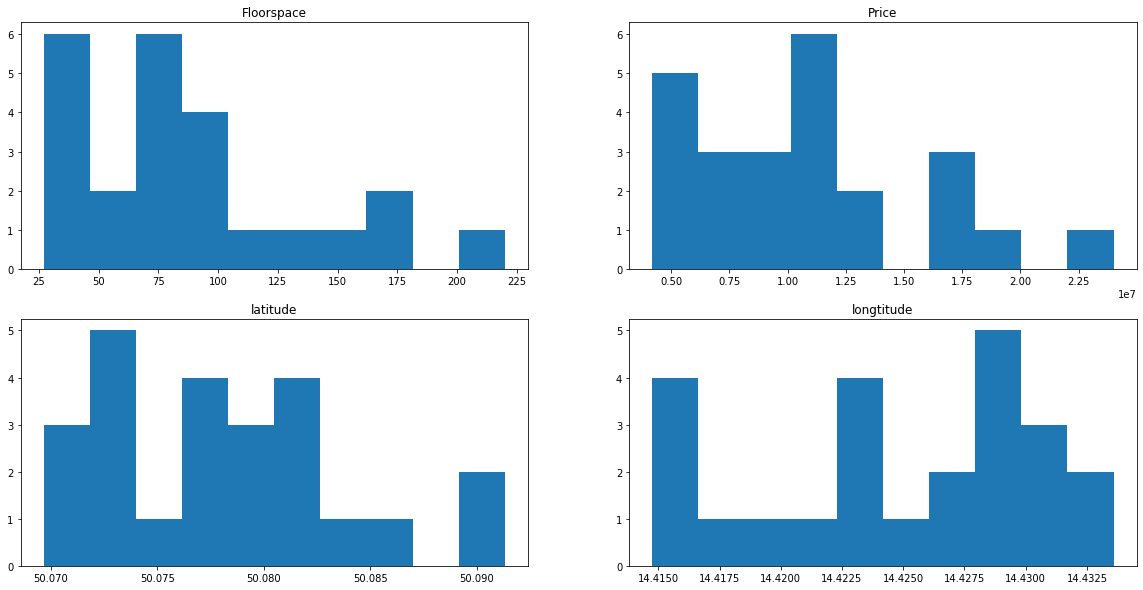

In [21]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.hist(num_NM_sale['Floorspace'])
plt.title('Floorspace')

plt.subplot(2,2,2)
plt.hist(num_NM_sale['Price'])
plt.title('Price')

plt.subplot(2,2,3)
plt.hist(num_NM_sale['lat'])
plt.title('latitude')

plt.subplot(2,2,4)
plt.hist(num_NM_sale['long'])
plt.title('longtitude')

plt.show()

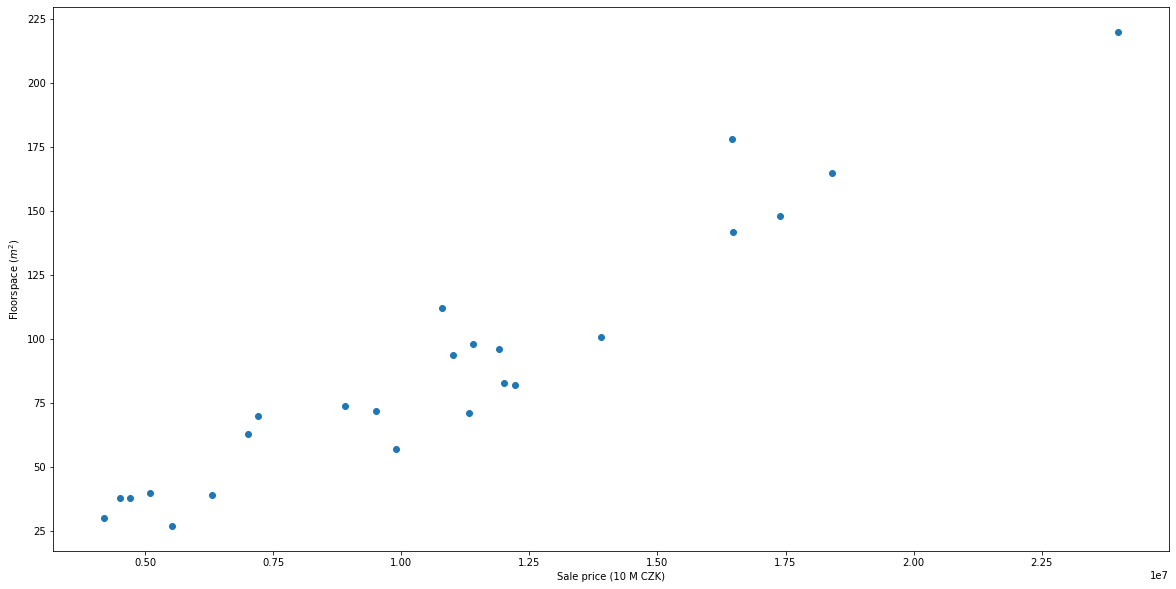

In [22]:
plt.figure(figsize = (20,10))
plt.scatter(num_NM_sale['Price'], num_NM_sale['Floorspace'])
plt.xlabel('Sale price (10 M CZK)')  # Add an x-label to the axes.
plt.ylabel('Floorspace ($m^2$)')  # Add a y-label to the axes.
plt.show()

In [23]:
print(num_NM_sale['Price'].describe())

count    2.400000e+01
mean     1.083683e+07
std      5.061933e+06
min      4.190000e+06
25%      6.825000e+06
50%      1.090000e+07
75%      1.264000e+07
max      2.400000e+07
Name: Price, dtype: float64


# Categorial variables - Sale


In [17]:
NM_sale.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 609207 to 596704
Data columns (total 24 columns):
Internet:                24 non-null object
Dispozice:               24 non-null object
Plocha:                  24 non-null object
Cena:                    24 non-null object
Město:                   24 non-null object
Městská část:            24 non-null object
Typ vlastnictví:         24 non-null object
Typ budovy:              24 non-null object
PENB:                    24 non-null object
Podlaží:                 23 non-null object
Balkón:                  24 non-null object
Terasa:                  24 non-null object
Výtah:                   24 non-null object
Garáž:                   24 non-null object
K dispozici od:          24 non-null object
lat                      24 non-null object
long                     24 non-null object
Typ vytápění:            13 non-null object
Podlaží v rámci domu:    12 non-null object
Vybavenost:              13 non-null object
Provedení:   

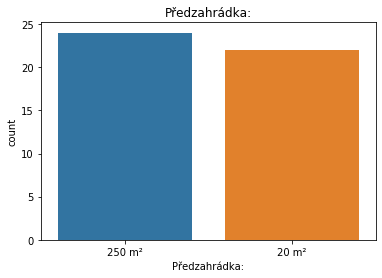

In [18]:
list(NM_sale.columns)
for i in list(NM_sale.columns):
    sns.countplot(NM_sale[i]).set_title(i)
    

IndexError: index 3 is out of bounds for axis 0 with size 3

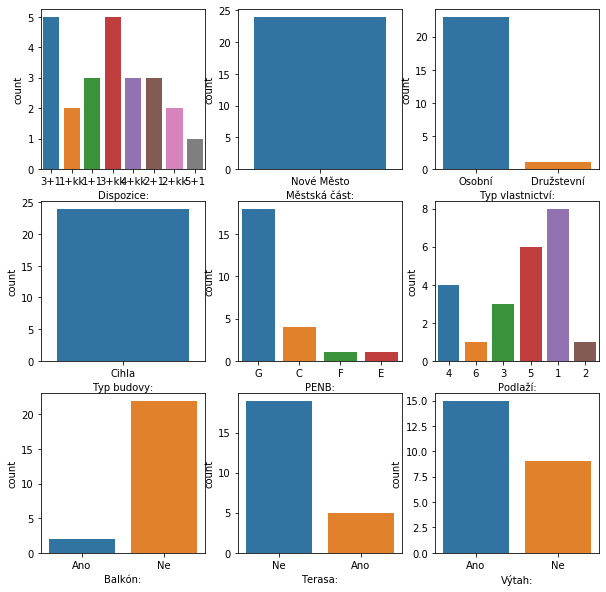

In [19]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
sns.countplot(NM_sale['Dispozice:'], ax=axs[0,0] )#.set_title("Rooms")
sns.countplot(NM_sale['Městská část:'], ax=axs[0,1])#.set_title('District')
sns.countplot(NM_sale['Typ vlastnictví:'], ax=axs[0,2])#.set_title('Ownership')

sns.countplot(NM_sale['Typ budovy:'], ax=axs[1,0])#.set_title('Building type')
sns.countplot(NM_sale['PENB:'], ax=axs[1,1])#.set_title('Energy performance')
sns.countplot(NM_sale['Podlaží:'], ax=axs[1,2])#.set_title('Floor number')

sns.countplot(NM_sale['Balkón:'], ax=axs[2,0])#.set_title('Balcony')
sns.countplot(NM_sale['Terasa:'], ax=axs[2,1])#.set_title('Terace')
sns.countplot(NM_sale['Výtah:'], ax=axs[2,2])#.set_title('Elevator')

# sns.countplot(NM_sale['Garáž:'], ax=axs[3,0])#.set_title('Garage')



# RENT data

In [24]:
NM_rent['Plocha:'] = NM_rent['Plocha:'].str.extract('(\d+)').astype(float)
NM_rent["Cena:"] = NM_rent["Cena:"].str.replace('.', '').str.extract('(\d+)').astype(float)
NM_rent["lat"] = NM_rent["lat"].astype(float)
NM_rent["long"] = NM_rent["long"].astype(float)

num_col = ["Plocha:", "Cena:", "lat", "long"]
num_NM_rent = NM_rent[num_col]
num_NM_rent = num_NM_rent.rename(columns=num_col_dict)
num_NM_rent.head()

,Floorspace,Price,lat,long
0,85.0,22000.0,50.078073,14.423947
1,77.0,23000.0,50.070536,14.418702
2,39.0,15500.0,50.070427,14.418905
3,81.0,25500.0,50.070536,14.418702
4,35.0,11500.0,50.070531,14.430608


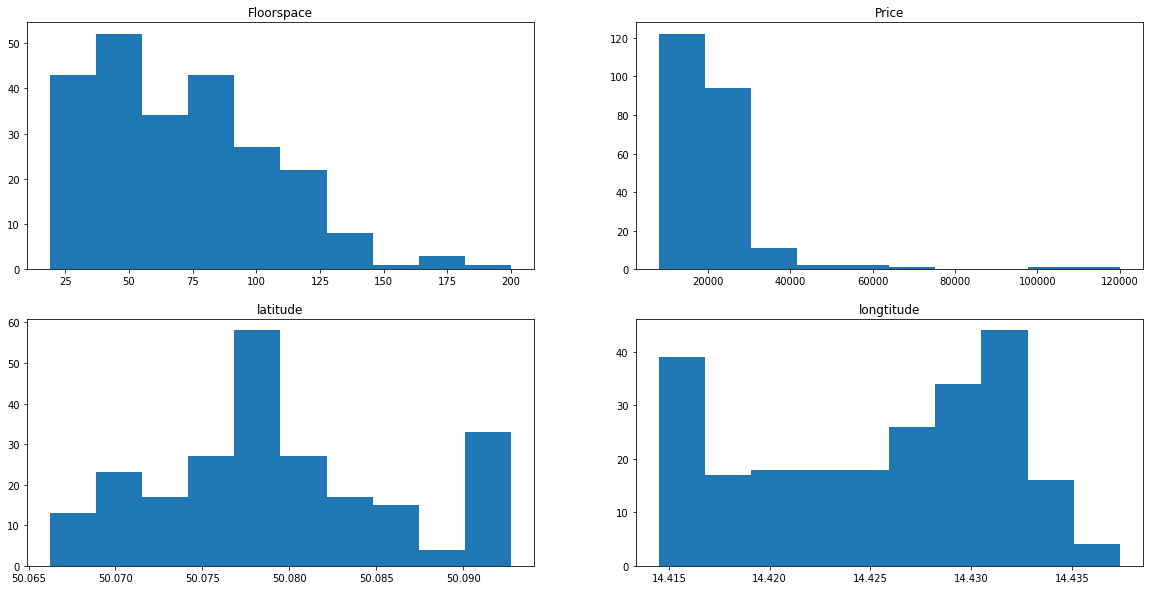

In [25]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.hist(num_NM_rent['Floorspace'])
plt.title('Floorspace')

plt.subplot(2,2,2)
plt.hist(num_NM_rent['Price'])
plt.title('Price')

plt.subplot(2,2,3)
plt.hist(num_NM_rent['lat'])
plt.title('latitude')

plt.subplot(2,2,4)
plt.hist(num_NM_rent['long'])
plt.title('longtitude')

plt.show()

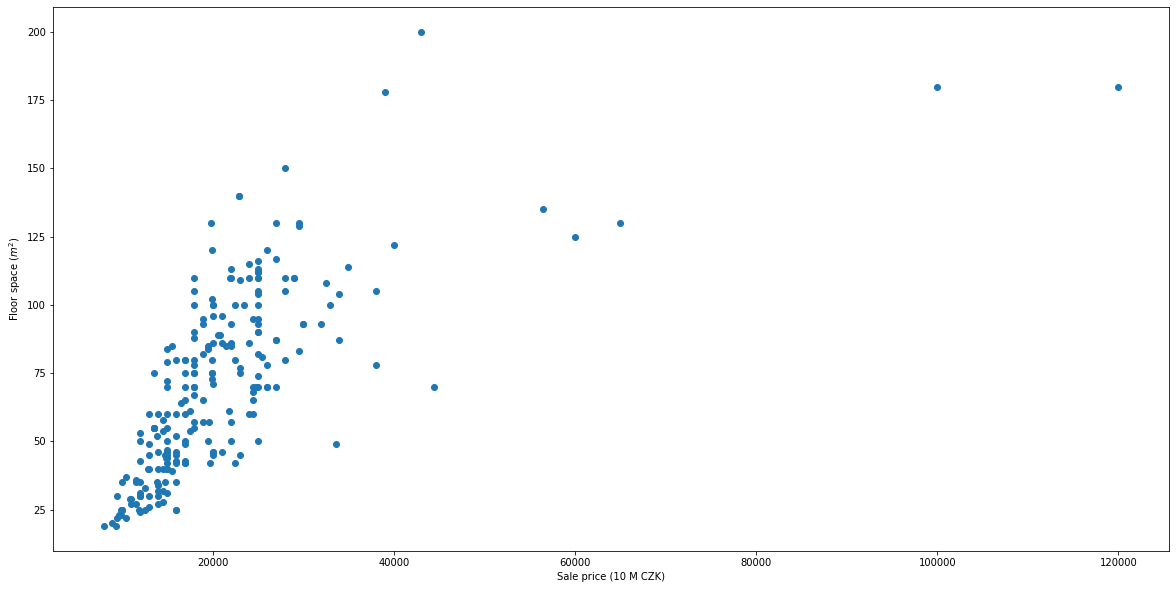

In [26]:
plt.figure(figsize = (20,10))
plt.scatter( num_NM_rent['Price'], num_NM_rent['Floorspace'])
plt.xlabel('Sale price (10 M CZK)')  # Add an x-label to the axes.
plt.ylabel('Floor space ($m^2$)')  # Add a y-label to the axes.
plt.show()

In [27]:
NM_rent.head()

,Číslo inzerátu:,Internet:,Dispozice:,Plocha:,Cena:,Poplatky:,Vratná kauce:,Město:,Městská část:,Typ vlastnictví:,...,lat,long,Vybavenost:,Stáří:,Provedení:,Typ vytápění:,Podlaží v rámci domu:,Rekonstrukce:,Předzahrádka:,Novostavba:
0,602233,NaN,3+1,85.0,22000.0,3.000 Kč,25.000 Kč,Praha,Nové Město,Osobní,...,50.078073,14.423947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,483454,NaN,3+kk,77.0,23000.0,750 Kč,NaN,Praha,Nové Město,Osobní,...,50.070536,14.418702,Vybavený,1 - 10,standardní: běžné materiály a technologie,plynový kotel,první až předposlední podlaží,vše,NaN,NaN
2,524239,NaN,2+kk,39.0,15500.0,750 Kč,NaN,Praha,Nové Město,Osobní,...,50.070427,14.418905,Vybavený,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,558443,NaN,3+1,81.0,25500.0,3.000 Kč,NaN,Praha,Nové Město,Osobní,...,50.070536,14.418702,Vybavený,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,602091,NaN,1+kk,35.0,11500.0,1.500 Kč,15.000 Kč,Praha,Nové Město,Družstevní,...,50.070531,14.430608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Regression analysis
### OLS

In [28]:
y = num_NM_rent['Price']
X = num_NM_rent['Floorspace']
X = sm.add_constant(X)
NMr_ols_model = sm.OLS(y, X)
NMr_ols_results = NMr_ols_model.fit()
print(NMr_ols_results.summary())

C:\Users\janek\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     210.8
Date:                Thu, 21 May 2020   Prob (F-statistic):           2.09e-34
Time:                        11:24:13   Log-Likelihood:                -2446.9
No. Observations:                 234   AIC:                             4898.
Df Residuals:                     232   BIC:                             4905.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4175.1245   1272.859      3.280      0.0

### Quantile regression

In [29]:
NMr_qmod = smf.quantreg('Price ~ Floorspace', num_NM_rent)
NMr_qres = NMr_qmod.fit(q=.5)
print(NMr_qres.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  Price   Pseudo R-squared:               0.3646
Model:                       QuantReg   Bandwidth:                       2725.
Method:                 Least Squares   Sparsity:                        8848.
Date:                Thu, 21 May 2020   No. Observations:                  234
Time:                        11:24:17   Df Residuals:                      232
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7257.1429    666.302     10.892      0.000    5944.367    8569.919
Floorspace   168.5714      8.501     19.828      0.000     151.821     185.321


In [33]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = NMr_qmod.fit(q=q)
    return [q, res.params['Intercept'], res.params['Floorspace']] + \
            res.conf_int().loc['Floorspace'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('Price ~ Floorspace', num_NM_rent).fit()
ols_ci = ols.conf_int().loc['Floorspace'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['Floorspace'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

C:\Users\janek\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
C:\Users\janek\Anaconda3\lib\site-packages\statsmodels\regression\quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


      q            a           b          lb          ub
0  0.05  6473.529411  108.823529   93.387093  124.259966
1  0.15  6653.246755  129.870130  114.383124  145.357136
2  0.25  6512.727271  147.272727  131.545764  162.999691
3  0.35  6771.086568  156.626486  141.158711  172.094260
4  0.45  7768.942357  153.849507  137.347118  170.351897
5  0.55  7833.333337  166.666667  149.001310  184.332024
6  0.65  8035.714285  178.571429  158.601891  198.540966
7  0.75  6696.428573  232.142857  207.035568  257.250146
8  0.85  5777.777781  277.777778  251.130873  304.424682
9  0.95     0.000006  500.000000  440.194819  559.805181
{'a': 4175.1244971875985, 'b': 235.77211400908504, 'lb': 203.77408695152258, 'ub': 267.7701410666475}


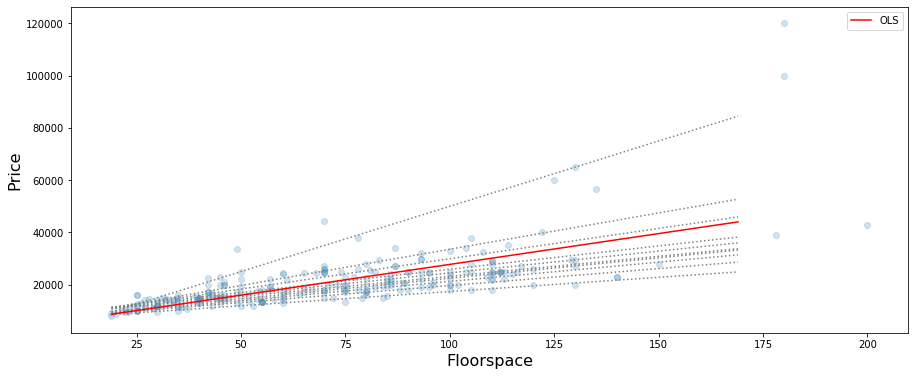

In [37]:
x = np.arange(num_NM_rent['Floorspace'].min(), num_NM_rent['Floorspace'].max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(15, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
# ax.scatter(num_NM_rent['Price'], num_NM_rent['Floorspace'], alpha=.2)
ax.scatter(num_NM_rent['Floorspace'],num_NM_rent['Price'], alpha = .2)
plt.xlabel('Sale price (10 M CZK)')  # Add an x-label to the axes.
plt.ylabel('Floor space ($m^2$)')  # Add a y-label to the axes.
# ax.set_xlim((10, 1000))
# ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Floorspace', fontsize=16)
ax.set_ylabel('Price', fontsize=16);

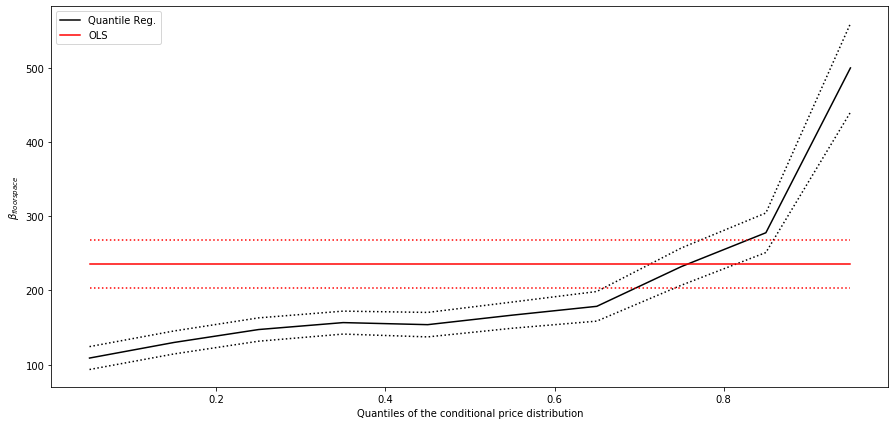

<Figure size 432x288 with 0 Axes>

In [36]:
plt.figure(figsize = (15,7))
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{floorspace}$')
plt.xlabel('Quantiles of the conditional price distribution')
plt.legend()
plt.show()
plt.savefig('Quantiles.png')